In [1]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams
import time
import seaborn as sns
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

%matplotlib inline

In [2]:
def mean_relative_error(target_values, predicted_values):
    return sum(abs(target_values - predicted_values))/sum(target_values)

def median_relative_error(target_values, predicted_values):
    return np.median(abs(target_values - predicted_values)/target_values)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_prediction_2(y_test, y_test_predicted, y_train, y_train_predicted) -> str:  
    test_mse = mean_squared_error(y_test, y_test_predicted)
    print('test_mse:', round(test_mse, 4))
    train_mse = mean_squared_error(y_train, y_train_predicted)
    print('train_mse:', round(train_mse, 4))
    test_rmse = mean_squared_error(y_test, y_test_predicted, squared=False)
    print('test_rmse:', round(test_rmse, 4))
    train_rmse = mean_squared_error(y_train, y_train_predicted, squared=False)
    print('train_rmse:', round(train_rmse, 4))
    test_mae = mean_absolute_error(y_test, y_test_predicted)
    print('test_mae:', round(test_mae, 4))
    train_mae = mean_absolute_error(y_train, y_train_predicted)
    print('train_mae:', round(train_mae, 4))
    test_mre = mean_relative_error(y_test, y_test_predicted)
    print('test_mre:', round(test_mre, 4))
    train_mre = mean_relative_error(y_train, y_train_predicted)
    print('train_mre:', round(train_mre, 4))
    test_medAE = median_absolute_error(y_test, y_test_predicted)
    print('test_medAE:', round(test_medAE, 4))
    train_medAE = median_absolute_error(y_train, y_train_predicted)
    print('train_medAE:', round(train_medAE, 4))
    test_medRE = median_relative_error(y_test, y_test_predicted)
    print('test_medRE:', round(test_medRE, 4))
    train_medRE = median_relative_error(y_train, y_train_predicted)
    print('train_medRE:', round(train_medRE, 4))
    test_mape = mean_absolute_percentage_error(y_test, y_test_predicted)
    print('test_mape:', round(test_mape, 4))
    train_mape = mean_absolute_percentage_error(y_train, y_train_predicted)
    print('train_mape:', round(train_mape, 4))
    return evaluate_prediction_2
    #return f'{round(test_mse, 4)}; {round(train_mse, 4)}; {round(test_rmse, 4)}; {round(train_rmse, 4)}; {round(test_mae, 4)}; {round(train_mae, 4)}; {round(test_mre, 4)}; {round(train_mre, 4)}; {round(test_medAE, 4)}; {round(train_medAE, 4)}; {round(test_medRE, 4)}; {round(train_medRE, 4)}; {round(test_mape, 4)}; {round(train_mape, 4)}'

In [3]:
input_file = open("D:\Master\Projekt im Master\DataSet\joinedExportv4.csv", "r")
df = pd.read_csv(input_file)
#df = pd.read_csv(input_file, nrows = 1000)
df.head()

,Unnamed: 0,tripId,startLongitude_x,startLatitude_x,endLongitude_x,endLatitude_x,startTime,startTimeYear,startTimeMonth,startTimeWeek,...,endTGC1000IndexY,endTGC500IndexY,endTGC250IndexY,endTGC150IndexY,endTGC100IndexY,endTGC50IndexY,endTGC25IndexY,endTGC15IndexY,endTGC10IndexY,endTGC5IndexY
0,0,138,-73.965675,40.760399,-73.946228,40.747871,2016-02-01T00:00:54Z,2016,2,5,...,20,41,82,136,205,410,820,1367,2050,4101
1,1,145,-74.007629,40.740795,-73.980873,40.745068,2016-02-01T00:00:58Z,2016,2,5,...,20,40,80,134,201,402,805,1343,2014,4029
2,2,126,-73.986862,40.739311,-73.956688,40.771107,2016-02-01T00:00:44Z,2016,2,5,...,23,46,93,156,234,469,939,1565,2348,4697
3,3,106,-73.997856,40.751511,-74.004951,40.743313,2016-02-01T00:00:35Z,2016,2,5,...,19,39,79,132,199,398,796,1328,1992,3984
4,4,167,-73.965324,40.766071,-73.941017,40.788322,2016-02-01T00:01:08Z,2016,2,5,...,25,51,102,171,256,513,1027,1712,2569,5138


In [4]:
newdf = df.rename(columns= {'timeBin20WWDSId': 'TripStartTime', 'startSGC15IndexX' : 'Pickup X-axis', 'startSGC15IndexY' : 'Pickup Y-axis', 'endSGC15IndexX' : 'Dropoff X-axis', 'endSGC15IndexY' : 'Dropoff Y-axis'})

In [5]:
feature_set = ['startTimeWeek', 'startTimeDay', 'TripStartTime', 'weatherHourlyTemp', 'weatherHourlyWind', 'weatherHourlyHumidity', 'weatherHourlyBarometer', 'Pickup X-axis', 'Pickup Y-axis', 'Dropoff X-axis', 'Dropoff Y-axis']
y_f = 'tripDuration'
sample_size = 1400000

In [6]:
dataset = newdf[feature_set + [y_f]].sample(sample_size)

train_dataset = dataset.sample(frac=0.8958165367732689, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
    
train_features = train_dataset.copy()
test_features = test_dataset.copy()
    
train_labels = train_features.pop(y_f)    
test_labels = test_features.pop(y_f)


In [ ]:
def train_dnn_model():    
    
    normalizer = preprocessing.Normalization()
    normalizer.adapt(np.array(train_features))

    dnn_model = tf.keras.Sequential([
        normalizer, 
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])
    
    dnn_model.compile(loss='mean_absolute_error',
                 optimizer=tf.keras.optimizers.Adam(0.001))
    
    global start
    start = int(time.time())

    global end
    end = int(time.time())
    #estimator = KerasRegressor(build_fn=dnn_model, validation_split = 0.2, batch_size=100, epochs=100, verbose=0)

    #dnn_model.save('models/' + config['name'])
    global plot_loss 
    
    return dnn_model

estimator = KerasRegressor(build_fn=train_dnn_model, validation_split = 0.2, epochs=200, verbose=2)
history = estimator.fit(train_features, train_labels)    

y_test_predicted = estimator.predict(test_features).flatten()
y_train_predicted = estimator.predict(train_features).flatten()

eval_results = evaluate_prediction_2(test_labels, y_test_predicted, train_labels, y_train_predicted)    
print(f'DNN_64_64; AllSelected; {int(end-start)};{eval_results}')   
print("Test R2 score: {:.2f}".format(estimator.score(test_labels, y_test_predicted)))    

    
    
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

Text(0, 0.5, 'Predicion Samples (Estimated time in seconds)')

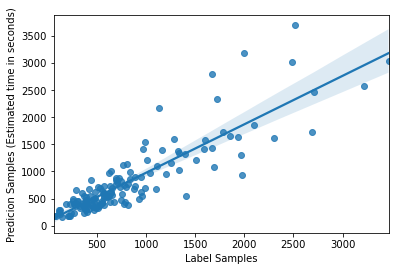

In [8]:
sampley_test= test_labels[:300:]
sampley_predreal= y_test_predicted[:300:]
sns.regplot(x = sampley_test, y = sampley_predreal)
plt.xlabel("Label Samples")
plt.ylabel("Predicion Samples (Estimated time in seconds)")

In [9]:
#fitted = estimator.predict(train_features)

In [10]:
len(test_labels), len(y_test_predicted)

(146, 146)

In [11]:
for i in range(0,20):
    print(y_test_predicted[i], "vs", test_labels.iloc[i])

1421.8513 vs 1584
719.5271 vs 731
386.47092 vs 447
871.5328 vs 720
817.2519 vs 741
1719.8369 vs 2685
431.9772 vs 668
1734.7349 vs 1780
984.11847 vs 832
1572.5774 vs 1601
588.2806 vs 749
1127.7683 vs 760
243.30385 vs 263
1136.2883 vs 801
615.009 vs 477
549.56134 vs 962
407.39737 vs 775
626.99005 vs 951
1425.4308 vs 1671
551.4972 vs 569


In [12]:
import shap
shap.initjs()

# Feature Importance using SHAP

In [13]:
#Using (145857) background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.

In [14]:
#2D numpy array for shap
def wrapper(X):
    return estimator.predict(X).flatten()

In [15]:
X_test_summary = shap.kmeans(test_features,100)#<-- Nearest 100 points, each one is weighted by the number of points they represent

In [16]:
explainer = shap.KernelExplainer(wrapper,X_test_summary)

4/4 - 0s


In [ ]:
X_test_sample = test_features.sample(1000)#must be 10000 atleast
shap_values  = explainer.shap_values(X_test_sample)

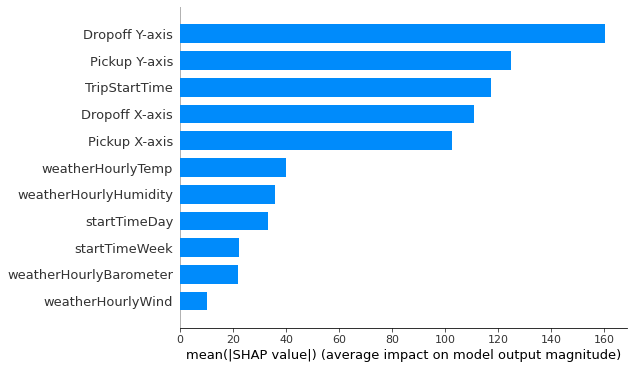

In [207]:
shap.summary_plot(shap_values, X_test_sample,plot_type="bar")

In [ ]:
explainer1 = shap.AdditiveExplainer(wrapper, X_test_sample)
shap_values1  = explainer1(X_test_sample)

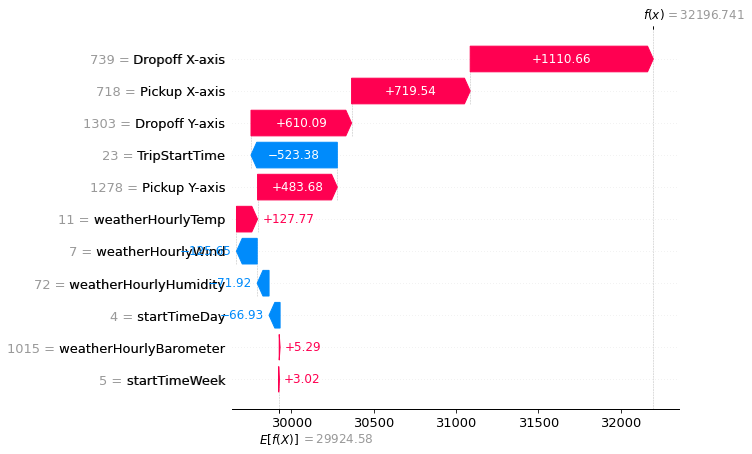

In [210]:
shap.plots.waterfall(shap_values1[0], max_display=11)

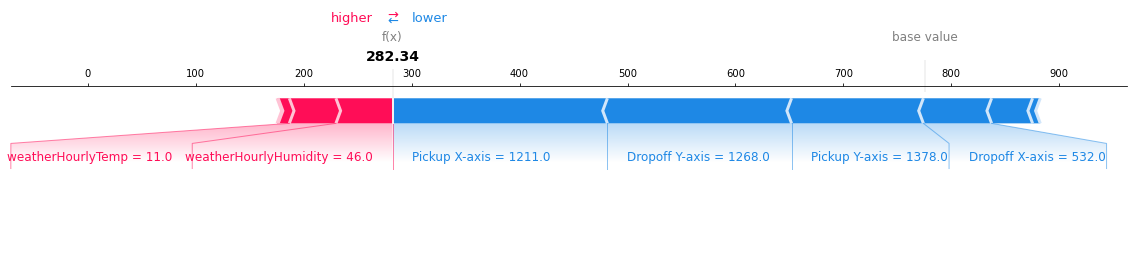

In [211]:
shap.force_plot(explainer.expected_value, shap_values[0], test_features.iloc[0],feature_set,matplotlib=True, show=True)

# PDPs

In [109]:
from pdpbox import pdp, get_dataset, info_plots

In [110]:
from sklearn.inspection import partial_dependence, plot_partial_dependence

In [111]:
feature_set

['startTimeWeek',
 'startTimeDay',
 'TripStartTime',
 'weatherHourlyTemp',
 'weatherHourlyWind',
 'weatherHourlyHumidity',
 'weatherHourlyBarometer',
 'Pickup X-axis',
 'Pickup Y-axis',
 'Dropoff X-axis',
 'Dropoff Y-axis']

4559/4559 - 4s
4559/4559 - 3s


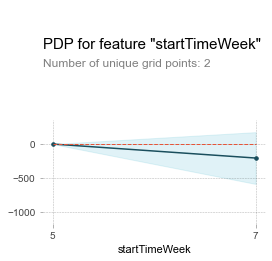

In [112]:
pdp_dnn = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'startTimeWeek')

pdp.pdp_plot(pdp_dnn, 'startTimeWeek', 
             x_quantile=True, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

4559/4559 - 4s
4559/4559 - 3s
4559/4559 - 3s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 3s
4559/4559 - 3s


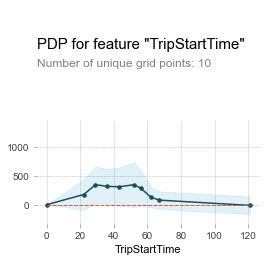

In [114]:
pdp_dnn = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'TripStartTime')

pdp.pdp_plot(pdp_dnn, 'TripStartTime', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

4559/4559 - 3s
4559/4559 - 3s
4559/4559 - 3s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s


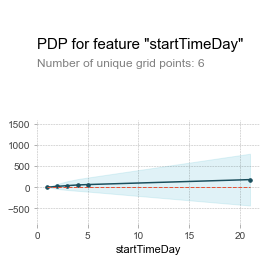

In [115]:
pdp_dnn = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'startTimeDay')

pdp.pdp_plot(pdp_dnn, 'startTimeDay', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 3s
4559/4559 - 3s
4559/4559 - 3s
4559/4559 - 3s


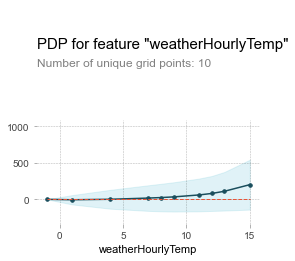

In [116]:
pdp_dnn = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'weatherHourlyTemp')

pdp.pdp_plot(pdp_dnn, 'weatherHourlyTemp', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

4559/4559 - 4s
4559/4559 - 3s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s


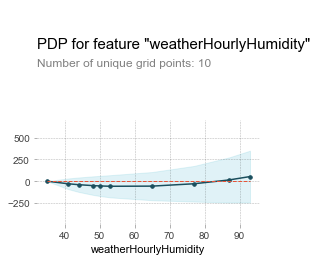

In [117]:
pdp_dnn = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'weatherHourlyHumidity')

pdp.pdp_plot(pdp_dnn, 'weatherHourlyHumidity', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s


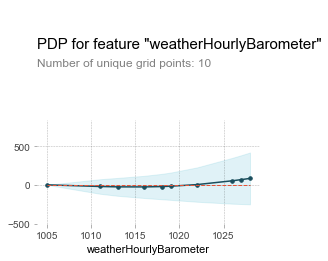

In [118]:
pdp_dnn = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'weatherHourlyBarometer')

pdp.pdp_plot(pdp_dnn, 'weatherHourlyBarometer', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s


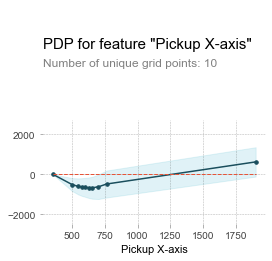

In [119]:
pdp_dnn = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'Pickup X-axis')

pdp.pdp_plot(pdp_dnn, 'Pickup X-axis', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

4559/4559 - 3s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s


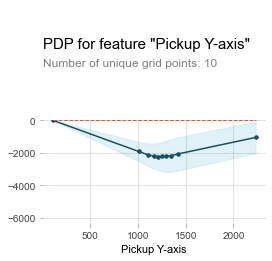

In [120]:
pdp_dnn = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'Pickup Y-axis')

pdp.pdp_plot(pdp_dnn, 'Pickup Y-axis', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s


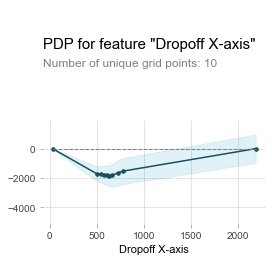

In [121]:
pdp_dnn = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'Dropoff X-axis')

pdp.pdp_plot(pdp_dnn, 'Dropoff X-axis', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s


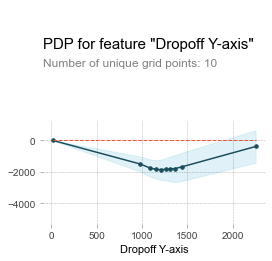

In [122]:
pdp_dnn = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'Dropoff Y-axis')

pdp.pdp_plot(pdp_dnn, 'Dropoff Y-axis', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s
4559/4559 - 4s


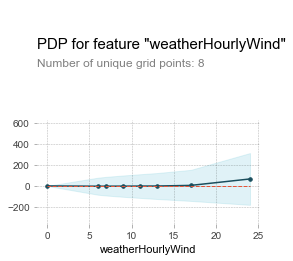

In [123]:
pdp_dnn = pdp.pdp_isolate(model = estimator, 
                                dataset = test_features, 
                                model_features = feature_set,
                                feature = 'weatherHourlyWind')
                               

pdp.pdp_plot(pdp_dnn, 'weatherHourlyWind', 
             x_quantile=False, 
            plot_pts_dist=False, figsize= (4,4))
plt.show()

# Feature importance using Eli5

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction

In [ ]:
perm = PermutationImportance(estimator, random_state=1).fit(test_features, test_labels)

In [82]:
eli5.show_weights(perm, feature_names = test_features.columns.tolist())

Weight,Feature
351.3045 ± 1.0220,Dropoff Y-axis
318.8853 ± 0.9902,Pickup Y-axis
263.7613 ± 2.3933,Dropoff X-axis
243.8942 ± 1.2492,Pickup X-axis
103.5301 ± 0.8014,TripStartTime
38.7171 ± 0.4882,startTimeDay
36.2723 ± 0.3595,weatherHourlyTemp
35.8440 ± 0.3487,weatherHourlyBarometer
28.1462 ± 0.5128,weatherHourlyHumidity
18.7962 ± 0.4973,startTimeWeek
